[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)



# 状态简化器（State Reducers）

## 评审（Review）

We covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic`, or `Dataclasses`.
 
## Goals

我们介绍了几种定义 LangGraph 状态模式的方法，包括 `TypedDict`、`Pydantic` 或 `Dataclasses`。
## 目标

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

现在，我们将深入探讨 reducers，它规定了状态模式中特定键/通道的状态更新如何执行。



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## 默认覆盖状态（Default overwriting state）

Let's use a `TypedDict` as our state schema.

让我们使用 `TypedDict` 作为我们的状态模式。



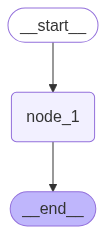

In [1]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 2}

Let's look at the state update, `return {"foo": state['foo'] + 1}`.

让我们看一下状态更新，`return {"foo": state['foo'] + 1}`。

As discussed before, by default LangGraph doesn't know the preferred way to update the state.
 
So, it will just overwrite the value of `foo` in `node_1`: 

如前所述， 默认情况下，LangGraph 不知道更新状态的优选方式。

因此，它只会覆盖 `foo` 在 `node_1` 中的值：

```
return {"foo": state['foo'] + 1}
```
 
If we pass `{'foo': 1}` as input, the state returned from the graph is `{'foo': 2}`.

```
return {"foo": state['foo'] + 1}
```

如果我们传递 `{'foo': 1}` 作为输入，则从图返回的状态为 `{'foo': 2}`。

## 分支（Branching）

Let's look at a case where our nodes branch.

让我们来看一个节点分支的情况。



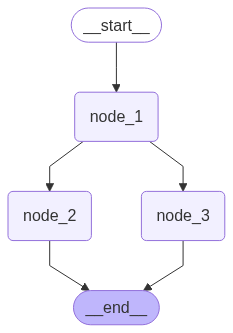

In [3]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


We see a problem! 

我们发现了一个问题！

Node 1 branches to nodes 2 and 3.

节点 1 分支到节点 2 和 3。

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

节点 2 和 3 并行运行，这意味着它们在图的同一步骤中运行。

They both attempt to overwrite the state *within the same step*. 

它们都试图在 *同一步骤内* 覆盖状态。

This is ambiguous for the graph! Which state should it keep? 

这对图形来说是模糊的！它应该保持哪种状态？



## 减少器（Reducers）

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) 为我们提供了一种解决此问题的通用方法。

They specify how to perform updates.

他们指定了如何执行更新。

We can use the `Annotated` type to specify a reducer function. 

我们可以使用 `Annotated` 类型来指定一个 reducer 函数。

For example, in this case let's append the value returned from each node rather than overwriting them.

例如，在这种情况下，让我们将每个节点返回的值附加到结果中，而不是覆盖它们。

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

我们只需要一个可以执行此操作的缩减器：`operator.add` 是 Python 内置 operator 模块中的一个函数。

When `operator.add` is applied to lists, it performs list concatenation.

当 `operator.add` 应用于列表时，它执行列表连接。



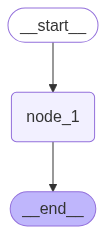

In [7]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

Now, our state key `foo` is a list.

现在，我们的状态键 `foo` 是一个列表。

This `operator.add` reducer function will append updates from each node to this list. 

这个 `operator.add` 汇总函数会将每个节点的更新追加到此列表中。



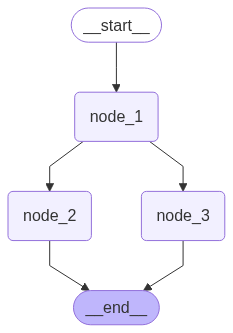

In [9]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

我们可以看到，节点 2 和节点 3 的更新是并行执行的，因为它们处于同一步骤中。



In [10]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

Now, let's see what happens if we pass `None` to `foo`.

现在，让我们看看如果我们将 `None` 传递给 `foo` 会发生什么。

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`. 

我们看到一个错误，因为我们的 reducer（`operator.add`）尝试将 `NoneType` 作为输入连接到 `node_1` 中的列表。



In [11]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


In [9]:
from typing_extensions import TypedDict
from typing import Annotated
from operator import add
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

## 自定义 Reducers（Custom Reducers）

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state). 

为了解决像这样的情况，[we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state).

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

例如，我们来定义自定义的归约逻辑，用于合并列表并处理其中一个或两个输入可能是 `None` 的情况。



In [10]:
def reduce_list(left: list | None, right: list | None) -> list:
    """安全地合并两个列表，处理其中一个或两个输入可能为 None 的情况。

    参数：
        left (list | None): 要合并的第一个列表，或 None。
        right (list | None): 要合并的第二个列表，或 None。

    返回：
        list: 一个包含两个输入列表所有元素的新列表。
               如果输入为 None，则将其视为空列表。
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

In `node_1`, we append the value 2.

在 `node_1` 中，我们追加值 2。



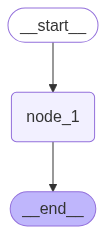

TypeError occurred: can only concatenate list (not "NoneType") to list


In [11]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Now, try with our custom reducer. We can see that no error is thrown.

现在，尝试使用我们自定义的 reducer。我们可以看到没有抛出任何错误。



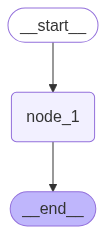

---Node 1---
{'foo': [2]}


In [12]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## 消息（Messages）

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

在模块1中，我们展示了如何使用内置的 reducer `add_messages` 来处理状态中的消息。

We also showed that [PROTECTED$12$ is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate). 

我们还展示了 [PROTECTED$12$ is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)。

* `MessagesState` has a built-in `messages` key 
* It also has a built-in `add_messages` reducer for this key

*`MessagesState` 内置了一个 `messages` 键* 它还为该键内置了一个 `add_messages` 合并器

These two are equivalent. 

这两个是等价的。

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


我们将通过 `MessagesState` 类使用 `from langgraph.graph import MessagesState`，以简洁起见。



In [ ]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# 定义一个自定义的 TypedDict，其中包含一个带有 add_messages reducer 的消息列表。
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# 使用 MessagesState ，它包含带有 add_messages reducer 的 messages 键。
class ExtendedMessagesState(MessagesState):
    # 添加除 messages 之外所需的任何键， messages 是预构建的。
    added_key_1: str
    added_key_2: str
    # etc

Let's talk a bit more about usage of the `add_messages` reducer.

让我们更多地讨论一下 `add_messages` reducer 的用法。



In [13]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='f470d868-cf1b-45b2-ae16-48154cd55c12'),
 HumanMessage(content="I'm looking for information on marine biology.", name='Lance', id='a07a88c5-cb2a-4cbd-9485-5edb9d658366'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model', id='7938e615-86c2-4cbb-944b-c9b2342dee68')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

因此，我们可以看到 `add_messages` 允许我们将消息附加到状态中的 `messages` 键。

### 重写（Re-writing）

Let's show some useful tricks when working with the `add_messages` reducer.

在使用 `add_messages` reducer 时，让我们展示一些有用的技巧。

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

如果我们传递的消息与 `messages` 列表中已有的消息具有相同的 ID，则该消息将被覆盖！



In [14]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", name='Lance', id='2')]

### 删除（Removal）

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). 

`add_messages` 也 [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/)。

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

为此，我们简单地使用 [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) 来自 `langchain_core`。



In [15]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', id='1'), RemoveMessage(content='', id='2')]


/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_17703/3097054180.py:10: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]


In [16]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', name='Lance', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.

我们可以看到，消息 ID 1 和 2 如 `delete_messages` 所指出的那样被 reducer 移除。

We'll see this put into practice a bit later.

我们稍后会看到这个被付诸实践。

